# Women's World Cup


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from IPython.core.display import display, HTML

import plots as ps

sns.set()
sns.set_palette("GnBu_d", 6)
%matplotlib inline

def create_link(id):
    display(HTML(f'<a id={id}></a>'))

## Analysing Data

In [2]:
scores_raw = pd.read_csv('womens_world_cup_data.csv')
ranking = pd.read_csv('womens_world_cup_rankings.csv')

display(scores_raw.shape)
display(ranking.shape)

(354, 7)

(150, 3)

In [3]:
scores_raw.head(3)

,Team_i,Team_j,home_i,home_j,score_i,score_j,year
0,china,thailand,0,0,4,0,2018
1,jordan,philippines,1,0,1,2,2018
2,philippines,china,0,0,0,3,2018


In [4]:
ranking.head(3)

,rank,team,rating
0,1,United States,2101
1,2,Germany,2072
2,3,England,2049


In [5]:
scores = scores_raw.drop(columns=['home_i', 'home_j'])
display(scores.info())
display(scores.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 5 columns):
Team_i     354 non-null object
Team_j     354 non-null object
score_i    354 non-null int64
score_j    354 non-null int64
year       354 non-null int64
dtypes: int64(3), object(2)
memory usage: 13.9+ KB


None

,Team_i,Team_j,score_i,score_j,year
0,china,thailand,4,0,2018
1,jordan,philippines,1,2,2018
2,philippines,china,0,3,2018
3,thailand,jordan,6,1,2018
4,jordan,china,1,8,2018


In [6]:
ranking.team = ranking.team.apply(lambda x: x.lower())
ranking.head(3)

,rank,team,rating
0,1,united states,2101
1,2,germany,2072
2,3,england,2049


### Guarantee that team I and team J respect lexical order

In [7]:
scores.loc[scores['Team_j'] < scores['Team_i'], ['Team_i', 'score_i', 'Team_j', 'score_j']] = \
    scores.loc[scores['Team_j'] < scores['Team_i'], ['Team_j', 'score_j', 'Team_i', 'score_i']].values
        

scores.head()

,Team_i,Team_j,score_i,score_j,year
0,china,thailand,4,0,2018
1,jordan,philippines,1,2,2018
2,china,philippines,3,0,2018
3,jordan,thailand,1,6,2018
4,china,jordan,8,1,2018


### Merging DataFrames

In [8]:
all_matches_i_j = (scores.merge(ranking, left_on='Team_i', right_on='team')
                         .rename(columns={'Team_i': 'team_i',
                                          'rating': 'rating_i',
                                          'rank': 'rank_i'})
                         .drop(columns=['team'])
                         .merge(ranking, left_on='Team_j', right_on='team')
                         .rename(columns={'Team_j': 'team_j',
                                          'rating': 'rating_j',
                                          'rank': 'rank_j'})
                         .drop(columns=['team']))


all_matches = all_matches_i_j.rename(columns={'team_i': 'team_a',
                                              'score_i': 'score_a',
                                              'rank_i': 'rank_a',
                                              'rating_i': 'rating_a',
                                              'team_j': 'team_b',
                                              'score_j': 'score_b',
                                              'rank_j': 'rank_b',
                                              'rating_j': 'rating_b',})

all_matches.head()

,team_a,team_b,score_a,score_b,year,rank_a,rating_a,rank_b,rating_b
0,china,thailand,4,0,2018,16,1866,34,1658
1,china,thailand,3,1,2018,16,1866,34,1658
2,jordan,thailand,1,6,2018,54,1440,34,1658
3,philippines,thailand,1,3,2018,74,1347,34,1658
4,australia,thailand,2,2,2018,6,2003,34,1658


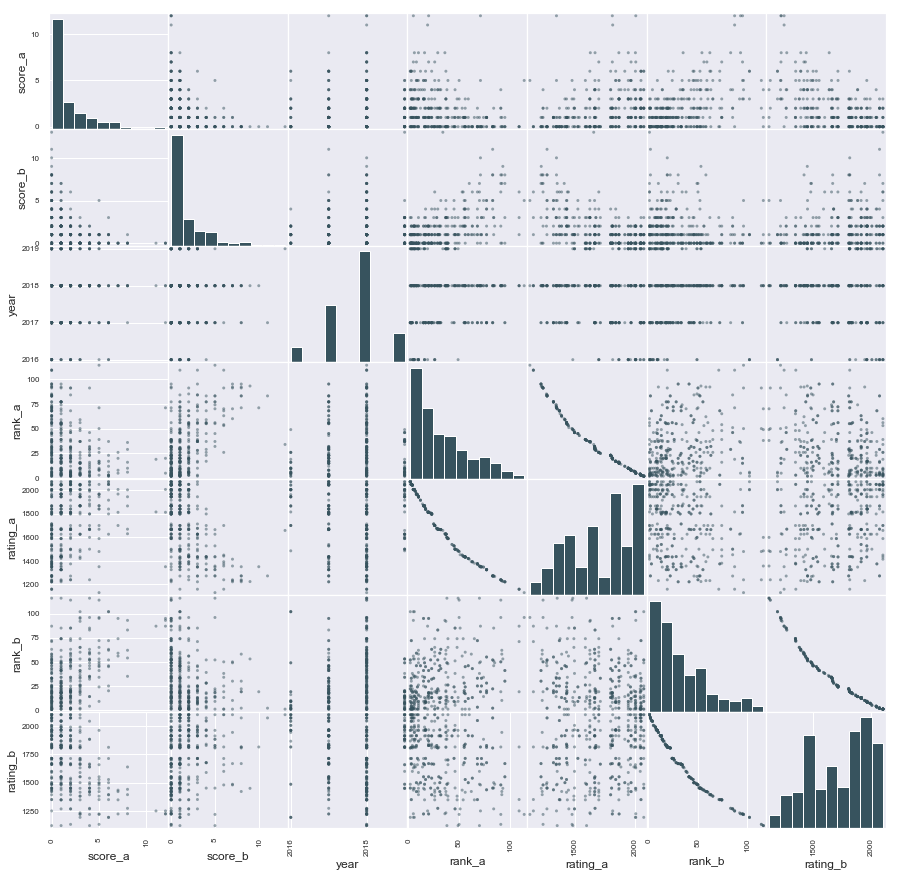

In [9]:
pd.plotting.scatter_matrix(all_matches, figsize=(15,15));

Some points:

countries with more rating play more games. as we can see in `rating_i X rating_i` *(equal to rank_i, rating_j and rank_j)*

There are more games at 2018.

There are some correlations between scores of A and rating that 

In [10]:
all_matches.sample(2, random_state=23)

,team_a,team_b,score_a,score_b,year,rank_a,rating_a,rank_b,rating_b
334,czech republic,iceland,1,1,2017,29,1669,22,1806
286,norway,slovakia,6,1,2017,12,1915,46,1499


# Model - Preprocess

For this first model we want to predict which team wons the match.

So, for that we are going to create a column target which says which one wins.

In [11]:
all_matches['target'] = 'draw'
all_matches.loc[all_matches.score_a > all_matches.score_b, ['target']] = 'win_a'
all_matches.loc[all_matches.score_a < all_matches.score_b, ['target']] = 'win_b'
print(f"amount of target values: {all_matches['target'].nunique()}")

amount of target values: 3


In [12]:
for c in all_matches.columns:
    print(f'{c} = {all_matches[c].unique()} \n')

team_a = ['china' 'jordan' 'philippines' 'australia' 'chile' 'sweden' 'argentina'
 'brazil' 'england' 'nigeria' 'equatorial guinea' 'mali' 'germany'
 'south africa' 'russia' 'netherlands' 'denmark' 'croatia' 'hungary'
 'italy' 'canada' 'czech republic' 'faroe islands' 'france' 'scotland'
 'portugal' 'austria' 'israel' 'finland' 'serbia' 'japan' 'new zealand'
 'norway' 'south korea' 'panama' 'mexico' 'trinidad' 'jamaica' 'colombia'
 'thailand' 'albania' 'belarus' 'poland' 'cameroon' 'bolivia'
 'new caledonia' 'cook islands' 'fiji' 'belgium' 'costa rica' 'cuba'
 'algeria' 'ghana' 'ireland' 'northern ireland' 'paraguay' 'peru'
 'ecuador' 'bosnia and herzegovina' 'papua new guinea' 'samoa'
 'kazakhstan' 'moldova' 'iceland'] 

team_b = ['thailand' 'philippines' 'jordan' 'japan' 'south africa' 'sweden'
 'germany' 'spain' 'south korea' 'vietnam' 'united states' 'scotland'
 'canada' 'zimbabwe' 'brazil' 'new zealand' 'italy' 'jamaica' 'ghana'
 'cameroon' 'mali' 'nigeria' 'netherlands' 'zambia' 

We defined ratings as continuous variable and all others are going to be categorical.

In [13]:
X_raw = all_matches.drop(columns=['target', 'score_a', 'score_b'])
y_raw = all_matches['target']

display(X_raw.shape)
display(X_raw.sample(3, random_state=13))

display(y_raw.shape)
display(y_raw.sample(3, random_state=13))

(354, 7)

,team_a,team_b,year,rank_a,rating_a,rank_b,rating_b
259,italy,portugal,2017,15,1868,30,1668
245,kazakhstan,russia,2018,72,1349,25,1713
99,france,united states,2016,4,2043,1,2101


(354,)

259    win_a
245    win_b
99     win_b
Name: target, dtype: object

### Features

In [14]:
# enconding categorical features with one hot encoder
feat_cats = (pd.get_dummies(X_raw[['team_a',
                                   'team_b', 'year']].astype(str)))
print('shape categorycal:')
display(feat_cats.shape)

# normalization numerical features
from sklearn import preprocessing

feat_nums_raw = preprocessing.scale(X_raw[['rating_a', 'rating_b']])
feat_nums = pd.DataFrame(feat_nums_raw, columns=['rating_a', 'rating_b'])
print('describe numerical:')
display(feat_nums.describe())

# merging data
X = feat_nums.join(feat_cats)
print('shape all merged:')
display(X.shape)

shape categorycal:


(354, 134)

describe numerical:


,rating_a,rating_b
count,3.540000e+02,3.540000e+02
mean,-4.014366e-17,3.211493e-16
std,1.001415e+00,1.001415e+00
min,-2.198113e+00,-2.267244e+00
25%,-8.723496e-01,-8.726298e-01
50%,1.655783e-02,1.752364e-01
75%,9.624465e-01,7.658519e-01
max,1.380309e+00,1.474590e+00


shape all merged:


(354, 136)

##### About Cross Validation

We have to realize that we have few data points, because of that we are NOT follow the default data split:
`Train | Cross Validation | Test`

We are going to use kfold trying to not throw data away. We will define 5 buckets and then we are going to train each algorithm proposed 5 times, using k-1 bucket, and evaluate metric with the one that remains. In conclusion, we will have 5 metrics for each model, the final metric for each model is the average of those metrics. After that, we are going to compare each model to choose the best one.

We will using Stratified Kfold to guarantee that classes are equally devided among the folds.

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

num_folds = 5
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=6)
k_fold_indexes = [(train, test) for train, test in kf.split(X, y_raw)]

labels=['win_a', 'draw', 'win_b']

def train_model_k_fold(model, score, train_data=X, target_data=y_raw):
    scores = []
    
    for train, test in k_fold_indexes:       
        X_train, X_test, y_train, y_test = \
            train_data.loc[train], train_data.loc[test], target_data.loc[train], target_data.loc[test]
        
        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))
        
    return np.mean(scores)

## The Model - First Scene - Compare some algorithms

Decision Tree: 0.5987891737891738
Logistic Regression: 0.7317663817663819
SVC kernel=linear: 0.6808404558404558
SVC kernel=poly: 0.6452279202279202
SVC kernel=rbf: 0.7204415954415956
SVC kernel=sigmoid: 0.7175213675213675
Random Forest: 0.6556980056980057
Gradient Boosting: 0.6440170940170941


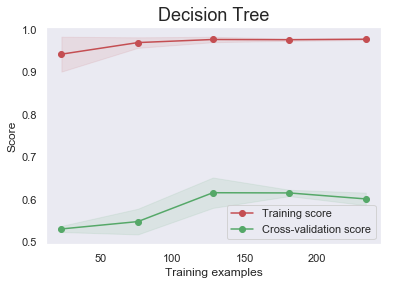

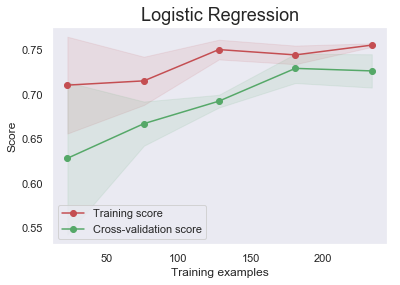

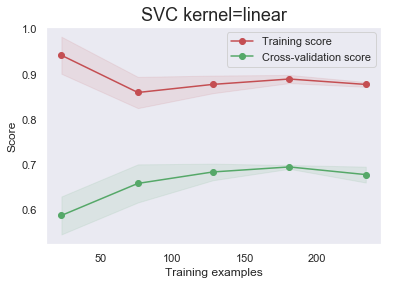

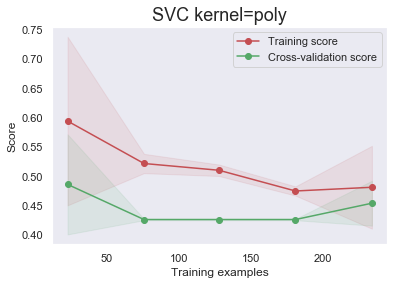

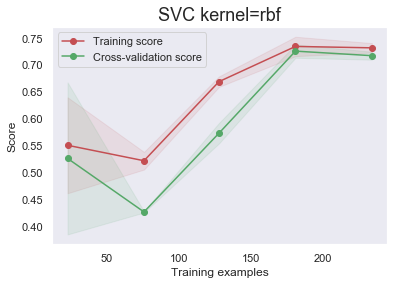

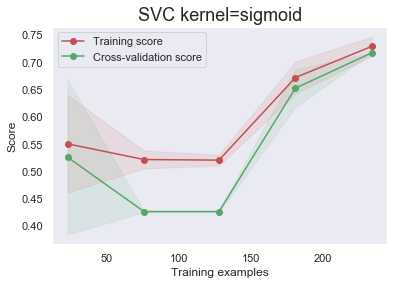

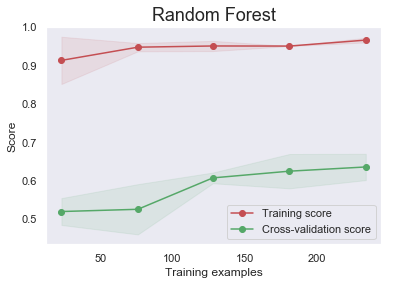

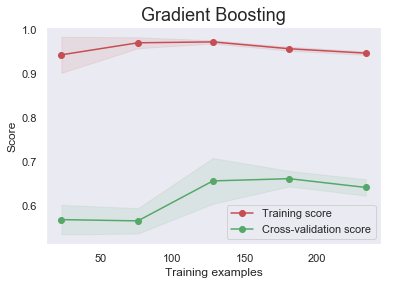

In [16]:
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

models = []

models.append(("Decision Tree", DecisionTreeClassifier(random_state=4)))
models.append(("Logistic Regression", LogisticRegression(solver='lbfgs', C=0.1, multi_class='auto', random_state=4)))
models.append(("SVC kernel=linear", SVC(kernel='linear', random_state=4)))
models.append(("SVC kernel=poly", SVC(kernel='poly', gamma='auto', random_state=23)))
models.append(("SVC kernel=rbf", SVC(kernel='rbf', gamma='auto', random_state=4)))
models.append(("SVC kernel=sigmoid", SVC(kernel='sigmoid', gamma='auto', random_state=4)))
models.append(("Random Forest", RandomForestClassifier(n_estimators=10, random_state=4)))
models.append(("Gradient Boosting", GradientBoostingClassifier(random_state=4)))

for name, model in models:
    print(f'{name}: {train_model_k_fold(model, accuracy_score)}')
    ps.plot_learning_curve(model, name, X, y_raw, cv=k_fold_indexes)


### Model Analysis

#### Decision Tree
`accuracy = 0.60`

Learning Curve show us that model extremelly overfits the data, the gap between the curves show this, so the model has high variance and acquiring more data could help this overfits behavior. But, decision trees tend to overfit a lot, even more when we don't do feature selection, like we didn't.

#### Logistic Regression
`accuracy = 0.73`

Learning Curve shows a very nice pattern: high score with close curves. We made a simple hyper parameter tunning at this stage (cheating, ok!) tunning C to regularize our 230+ features =D. Model answers very nice for our propose, one of the best choices.

#### SVC
`kernel: linear -> accuracy = 0.68`

`kernel: poly -> accuracy = 0.65`

`kernel: rbf -> accuracy = 0.72`

`kernel: sigmoid -> accuracy = 0.72`

At this point we made a simple hyper parameter tunning again (cheating), at my point of view, does no make sense choose an SVM model without choose a kernel, so we create 4 svc models, one for each basic kernel that has in sklearn.

Linear kernel has high variance (overfit the data) and poly kernel has high bias (underfit the data). Sigmoid and rbf are both nice!

#### Ensemble Methods
`Gradient Boosting -> accuracy = 0.66`

`Random Forest -> accuracy = 0.64`

Both have good metrics, but is easy to see in learning curves that both are overfitted. Both cases, I think that more data could fix this overfitting problem, sadly we don't have more data, so let's move on.

### Final Comments

There are a bunch of other models that we could explore, but at this point, for our propose, those are enough to find a good solution.

I decided to stress Linear Regression and SVC with sigmoid kernel to the next stages.

## The Model - Second Scene - Stressing some algorithms

At this part we will find the best hyper parameters to chossed models. 

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

scorer = make_scorer(accuracy_score)

### Linear Regression

In [24]:
parameters_lr = {'solver': ('newton-cg', 'sag', 'saga', 'lbfgs'),
              'C': np.unique(np.geomspace(0.001, 1, num=15, dtype=float)),
              'max_iter': np.unique(np.geomspace(50, 200, num=3, dtype=int))}

lr = LogisticRegression(multi_class='auto')

gd_model_lr = GridSearchCV(lr,
                           parameters,
                           n_jobs=4,
                           cv=k_fold_indexes,
                           iid=True,
                           scoring=scorer,
                           verbose=1)
gd_model_lr.fit(X, y_raw)

display(gd_model_lr.best_estimator_)
gd_model_lr.best_score_

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:    2.0s finished


LogisticRegression(C=0.22758459260747887, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=49, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

0.7372881355932204

## SVC

In [99]:
parameters_scv = {'kernel': ('sigmoid', 'rbf'),
                  'C': np.unique(np.geomspace(0.0001, 0.3, num=15, dtype=float)),
                  'coef0': np.unique(np.geomspace(0.001, 2, num=5, dtype=float)),
                  'class_weight': (None,
                                   'balanced',
                                   {'win_a': (354/(354-151)), 'win_b': (354/(354-151)), 'draw': (354/(354-52))}),
                  'gamma': list(np.unique(np.geomspace(0.0001, 10, num=15, dtype=float))) + ['scale'],
                  'tol': np.unique(np.geomspace(0.0001, 10, num=6, dtype=float))}


svc = SVC(kernel='linear', decision_function_shape='ovo', random_state=4)

gd_model_svc = GridSearchCV(svc,
                            parameters_scv,
                            n_jobs=8,
                            cv=k_fold_indexes,
                            iid=True,
                            scoring=scorer,
                            verbose=1)
gd_model_svc.fit(X, y_raw)


display(gd_model_svc.best_estimator_)
gd_model_svc.best_score_

Fitting 3 folds for each of 43200 candidates, totalling 129600 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 2867 tasks      | elapsed:    6.8s
[Parallel(n_jobs=8)]: Done 8367 tasks      | elapsed:   18.6s
[Parallel(n_jobs=8)]: Done 16067 tasks      | elapsed:   34.8s
[Parallel(n_jobs=8)]: Done 25967 tasks      | elapsed:   55.4s
[Parallel(n_jobs=8)]: Done 38067 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 52367 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 68867 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 87567 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 108467 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 129600 out of 129600 | elapsed:  4.5min finished


SVC(C=0.09558497852172912, cache_size=200,
    class_weight={'draw': 1.1721854304635762, 'win_a': 1.7438423645320198,
                  'win_b': 1.7438423645320198},
    coef0=0.00668740304976422, decision_function_shape='ovo', degree=3,
    gamma=0.3727593720314942, kernel='sigmoid', max_iter=-1, probability=False,
    random_state=4, shrinking=True, tol=0.1, verbose=False)

0.7401129943502824

Accuracy error: 0.7402421652421652


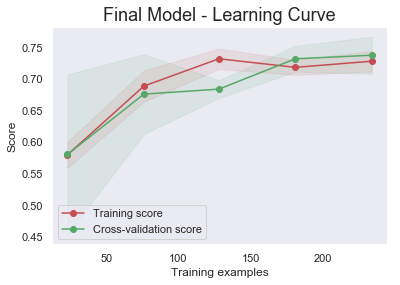

In [104]:
best_model = gd_model_svc.best_estimator_
print(f'Accuracy error: {train_model_k_fold(m, accuracy_score)}')
ps.plot_learning_curve(m, 'Final Model - Learning Curve', X, y_raw, cv=k_fold_indexes);

#### Feature importance based on decision tree model

In [67]:
dt_model = DecisionTreeClassifier(random_state=4)
dt_model.fit(X, y_raw)

feature_importance = [(f, importance) for f, importance in zip(X.columns, dt_model.feature_importances_)]

relevant_features = [f for f, i in feature_importance if i>0]
best_features = [f for f, i in feature_importance if i>0.01]
best_features
# relevant_features = [f, importance for f, importance in sorted(feature_importance, key=lambda x: x[1], reverse=True)]

# for f, importance in sorted(feature_importance, key=lambda x: x[1], reverse=True):
#     if importance > 0:
#         print(f, importance)

['rating_a',
 'rating_b',
 'team_a_austria',
 'team_a_brazil',
 'team_b_iceland',
 'team_b_japan',
 'team_b_norway',
 'year_2016',
 'year_2017',
 'year_2018',
 'year_2019']

In [ ]:
from sklearn.metrics import confusion_matrix
labels=['win_a', 'draw', 'win_b']
cm1=confusion_matrix(y_test, pred, labels=labels)
cm2=confusion_matrix(y_test, pred, labels=labels)

In [ ]:
import plots as ps

from importlib import reload
reload(ps)

ps.print_confusion_matrixes([cm1, cm2, cm2, cm2, cm2], labels)

In [ ]:
ax[i]